In [1]:
import numpy
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import os

# Questa funzione legge i file della oc_chamber
def reader(percorso_al_file):
    
    f = open(percorso_al_file)

    dati = dict() # struttura dati a dizionario in cui le chiavi sono le colonne e i valori sono stored in una lista
    dati["Event"] = list()
    dati["Answer"] = list()
    dati["RT"] = list()
    dati["Time"] = list()

    for line in f:
        to_list = line.split("\t")
        #row = list()
        for col in to_list:
            value = col.split(": ")
            if value[0] == "RT":
                value[1] = int(value[1])
            if value[0] == "Time":
                
                value[1] = dt.strptime(value[1][:-1],"%H:%M:%S_%d/%m/%Y")
            
            
            dati[value[0]].append(value[1])

    f.close()
    
    return dati

# calcola il numero totale e parziale di trial
def ntrial(dati):
    total = dict()
    total["total"] = 0
    total["right"] = 0
    total["left"] = 0

    for r in dati["Event"]:
        if r=="left":
            total["left"] = total["left"]+1
        elif r=="right":
            total["right"] = total["right"]+1
        total["total"] = total["total"] +1

    return total

# calcola accuracy di un vettore di yes e no
def accuracy(vec):
    tot_vec =0
    len_vec = len (vec)
    for l in vec:
        if l=="yes":
            tot_vec = tot_vec+1
    perc = 100*(tot_vec/len_vec)
    return perc

# seleziona i dati in una colonna [col] ugliale a [what] dalla colonna [where] 
def select(dati,col,what,where):
    result = list()
    i=0
    for ev in dati[col]:
        if ev == what:
            result.append(dati[where][i])
        i=i+1
    return result


#calcola differenze di una lista di datetime   
def diff(tempi):
    delta = list()
    for t in range(1,len(tempi)):
        delta.append( (tempi[t]-tempi[t-1]).seconds )
    return delta

# calcolo intertrial restituisce un dizionario con tempi totali e parzili
def intertrial(dati):
    intr=dict()
    
    #calcolo vettore intertrial totali e parziali
    totali = diff( dati["Time"] )
    left = diff( select(dati,"Event","left","Time") )
    right = diff( select(dati,"Event","right","Time") )
    
    # calcolo media e deviazione standard
    intr["total"] = ( np.mean(totali),np.std(totali) )
    intr["left"] = (np.mean(left),np.std(left) )
    intr["right"] = (np.mean(right),np.std(right) )
    
    return intr

# calcolo reaction time restituisce un dizionario con tempi totali e parzili
def reaction_times(dati):
    rt = dict()
    
    totali = dati["RT"]
    left = select(dati,"Event","left","RT")
    right = select(dati,"Event","right","RT")
    
    rt["total"] = ( np.mean(totali)/1000,np.std(totali)/1000 )
    rt["left"] = (np.mean(left)/1000,np.std(left)/1000 )
    rt["right"] = (np.mean(right)/1000,np.std(right)/1000 )
    
    return rt
    
#calcolo performance (accuracy) totale e parziale
def performance(dati):
    perf = dict()
    
    perf["total"] = accuracy(dati["Answer"])
    perf["left"] = accuracy(select(dati,"Event","left","Answer"))
    perf["right"] = accuracy(select(dati,"Event","right","Answer"))
    
    return perf

# info subject
def info_sub(subject):
    sub_info=dict()
    sub=subject.split("-")
    sub_info["sex"] = sub[0]
    sub_info["label"] = sub[1]
    sub_info["geno"] = sub[2]
    return sub_info

def show_performance(sub_info,dati):
    print("----------PERFORMANCE OUTPUT---------- Date: " + sub_info["day"])
    print("")
    print("Subject:")
    print("\tLabel:\t" + str(sub_info["label"]))
    print("\tSex:\t" + str(sub_info["sex"]))
    print("\tGeno:\t" + str(sub_info["geno"]))
    print("\tTime:\t" + str(sub_info["time"]))
    print("")
    numero_di_trial = ntrial(dati)
    print("Numero di Trial:")
    print("")
    print("\tTotal:\t" + str(numero_di_trial["total"]))
    print("\tLeft:\t" + str(numero_di_trial["left"]))
    print("\tRight:\t" + str(numero_di_trial["right"]))
    rt = reaction_times(dati)
    print("")
    print("Reaction Time:")
    print("")
    print("\tTotal:\t" +
          str(np.round(rt["total"][0],2))+
          " \u00B1 "+
          str(np.round(rt["total"][1],2))+
          " seconds"
         )
    print("\tLeft:\t" + 
          str(np.round(rt["left"][0],2))+
          " \u00B1 "+
          str(np.round(rt["left"][1],2))+
          " seconds"
         )
    print("\tRight:\t" + 
          str(np.round(rt["right"][0],2))+
          " \u00B1 "+
          str(np.round(rt["right"][1],2))+
          " seconds"
         )
    it = intertrial(dati)
    print("")
    print("Intertrial:")
    print("")
    print("\tTotal:\t" +
          str(np.round(it["total"][0],2))+
          " \u00B1 "+
          str(np.round(it["total"][1],2))+
          " seconds"
         )
    print("\tLeft:\t" + 
          str(np.round(it["left"][0],2))+
          " \u00B1 "+
          str(np.round(it["left"][1],2))+
          " seconds"
         )
    print("\tRight:\t" + 
          str(np.round(it["right"][0],2))+
          " \u00B1 "+
          str(np.round(it["right"][1],2))+
          " seconds"
         )

    perf = performance(dati)
    print("")
    print("Performance:")
    print("")
    print("\tTotal:\t" + str(np.round(perf["total"],2)) + " %")
    print("\tLeft:\t" + str(np.round(perf["left"],2))+" %")
    print("\tRight:\t" + str(np.round(perf["right"],2))+" %")

#legge tutte le sessioni di un soggetto
def read_subject(percorso,subject):
    
    sub_info=info_sub(subject)

    files = os.listdir(percorso + subject)

    tot_tr = list()
    tot_rt = list()
    tot_it = list()
    tot_perf = list()
    tot_ses = list()
    inc = 0
    for f in files:

        dati = reader(percorso + subject + "\\" + f)
        tr = ntrial(dati)
        tot_tr.append(tr["total"])
        rt = reaction_times(dati)
        tot_rt.append(rt["total"][0])
        it = intertrial(dati)
        tot_it.append(it["total"][0])
        perf = performance(dati)
        tot_perf.append(perf["total"])
        tot_ses.append(inc)
        inc+=1

    sub_info["tr"] = tot_tr
    sub_info["rt"] = tot_rt
    sub_info["it"] = tot_it
    sub_info["perf"] = tot_perf
    sub_info["session"] = tot_ses

    
    return sub_info  


# ESERCIZI
1. contare numero di trial
2. contare il tipo di trial
3. tempo di reazione medio
    * importare la libreria  [Numpy](https://docs.scipy.org/doc/numpy/reference/) usando la parola chiave **import**
    * usare la funzione [mean](http://lagrange.univ-lyon1.fr/docs/numpy/1.11.0/reference/generated/numpy.mean.html) della libreria Numpy
4. correttezza percentuale totale 
5. tempo di reazione medio 
6. [istogramma](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) tempo di reazione medio disegnando un [linea verticale](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.axes.Axes.axvline.html) sulla media
7. tempo di reazione medio per tipo di trial
8. correttezza percentuale per tipo di trial 
9. calcolare intertrial
    * trasformare le date da [stringhe](https://www.w3schools.com/python/python_ref_string.asp) a un oggetto [datetime](https://docs.python.org/2/library/datetime.html) usando il metodo [strptime](https://stackoverflow.com/questions/466345/converting-string-into-datetime)
    * calcolare i delta tra le date in [secondi](https://stackoverflow.com/questions/4362491/how-do-i-check-the-difference-in-seconds-between-two-dates)
    * modificare la funzione reader per trasformare le date direttamente in un oggetto datetime
    * plottare istogramma della distribuzione degli intertrial
10. creare libreria di funzioni che calcola le robe fatte giu
11. creare un output di prestazione della sessione
12. calcolare la prestazione settimana
13. creare sv file


In [2]:

percorso = "C:\\Users\\oldboy\\Documents\\GitHub\\corso_python\\dataset\\data\\"
subject = "F-0B0-WT"

cartella = percorso + subject

sub_info=info_sub(subject)

files = os.listdir(cartella)
print("Numero di sessioni: ",len(files))
ses = 1
dati = reader(cartella + "\\" + files[ses])
tm = files[ses].split("-")[0]
tm = dt.strptime(tm,"%Y%m%d_%H%M")

sub_info["day"]  = tm.strftime("%d/%m/%Y") 
sub_info["time"]  = tm.strftime("%H:%M")


show_performance(sub_info,dati)

Numero di sessioni:  9
----------PERFORMANCE OUTPUT---------- Date: 17/01/2018

Subject:
	Label:	0B0
	Sex:	F
	Geno:	WT
	Time:	11:40

Numero di Trial:

	Total:	25
	Left:	13
	Right:	12

Reaction Time:

	Total:	2.78 ± 1.92 seconds
	Left:	2.83 ± 1.8 seconds
	Right:	2.72 ± 2.05 seconds

Intertrial:

	Total:	24.5 ± 20.53 seconds
	Left:	47.17 ± 102.46 seconds
	Right:	33.09 ± 26.18 seconds

Performance:

	Total:	56.0 %
	Left:	53.85 %
	Right:	58.33 %


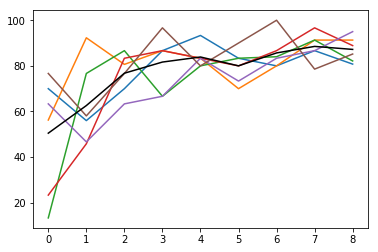

In [27]:

percorso = "C:\\Users\\oldboy\\Documents\\GitHub\\corso_python\\dataset\\data\\"
subs = os.listdir(percorso)

res_perf = list()
for i,s in enumerate(subs):
    sub_info = read_subject(percorso,s)
    res_perf.append(sub_info["perf"])
    plt.plot(sub_info["session"],sub_info["perf"])
    
media_nel_tempo = np.mean(np.array(res_perf),axis=0)

plt.plot(media_nel_tempo,color="k")
    
#plt.savefig(percorso + "esempio.png")
plt.show()

In [79]:
#with open(percorso + 'esempio.txt', 'a') as the_file:
#the_file.write("----------PERFORMANCE OUTPUT---------- Date: " + sub_info["day"] + "\n")
    

In [37]:
np.mean(np.array(res_perf),axis=0)



array([50.48611111, 62.58981252, 76.77419355, 81.66666667, 83.88888889,
       80.        , 85.66666667, 88.5300207 , 87.21508497])

In [40]:
sub_info["perf"]

[76.66666666666667,
 58.06451612903226,
 76.66666666666667,
 96.66666666666667,
 80.0,
 90.0,
 100.0,
 78.57142857142857,
 85.18518518518519]